### Images Classification
#### Multi-Layer Perceptron (MLP) / Neuron Nets

[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) is the dataset we are using for this assignment.


In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

### Read data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# X dim = 50000*3072
# Y dim = 50000*1
X = np.empty([0,3072])
Y = np.empty([0,1])
for i in range(1,6):
    file = "C:/Users/Donghan/Desktop/cifar-10-batches-py/data_batch_{}".format(i)
    dicts = unpickle(file)
    X = np.append(X, dicts[b'data'], axis = 0)
    Y = np.append(Y, np.expand_dims(dicts[b'labels'], axis = 1), axis = 0)
# print(X)
X = np.asarray(X)
Y = np.asarray(Y)

file_test = "C:/Users/Donghan/Desktop/cifar-10-batches-py/test_batch"
X_test = unpickle(file_test)[b'data']
Y_test = unpickle(file_test)[b'labels']

### Activation function for forward and backward layer

Options:
* sigmoid
* relu
* leaky_relu
* softmax

Others are not supported yet

In [3]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def leaky_relu(Z):
    return np.where(Z > 0, Z, Z * 0.01)
    
def leaky_relu_back(dl, Z, alpha=0.01):
    dx = np.ones_like(Z)
    dx[Z < 0] = alpha
    return dx*dl
    
def sigmoid_back(dA, Z):
    return dA * sigmoid(Z) * (1 - sigmoid(Z))

def relu_back(dA, Z):
    dZ = np.array(dA, copy = True)
    np.squeeze(dZ)[np.squeeze(Z) <= 0] = 0;
    return dZ

def logsumexp(Z):    
    Zmax = np.max(Z,axis=1)[:, None]    
    lse = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))[:, None]    
    return lse #N    

def softmax(
    u, # N x C
    ):
    u_exp = np.exp(u - np.max(u, 1)[:, None])
    return u_exp / np.sum(u_exp, axis=-1)[:, None]

def softmax_back(dA, u):
    return dA * softmax(u) * (1-softmax(u))

In [4]:
def gradients(X,#N x D              
              Y,#N x K              
              W,#M x K               
              V,#D x M             
             ):
    Z = logistic(np.dot(X, V))#N x M  
    N,D = X.shape    
    Yh = softmax(np.dot(Z, W))#N x K    
    dY = Yh - Y #N x K
    dW= np.dot(Z.T, dY)/N #M x K   
    dZ = np.dot(dY, W.T) #N x M    
    dV = np.dot(X.T, dZ * Z * (1 - Z))/N #D x M 
    return dW, dV

In [5]:
def GD(X, Y, M, lr=.1, eps=1e-9, max_iters=100000):
    N, D = X.shape
    N,K = Y.shape
    W = np.random.randn(M, K)*.01
    V = np.random.randn(D, M)*.01
    dW = np.inf*np.ones_like(W)
    t = 0
    while np.linalg.norm(dW) > eps and t < max_iters:
        dW, dV = gradients(X, Y, W, V)        
        W = W - lr*dW       
        V = V - lr*dV
        t+=1
    return W,V

### Neuron Network
#### Initialize the layer dimension and weights, bias

Weight Initialization technique refers to [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification
](https://arxiv.org/pdf/1502.01852.pdf)

![](https://miro.medium.com/max/1400/1*zxD6Nr6TyAb8JEG6oXAjkg.png)

* Speed up training
* Avoid gradient vanishing/exploding (No zero/inf in the computation)

In [6]:
def init_layers(input_dim, out_dim, batch_size):
    return np.random.randn(
            input_dim, out_dim) * np.sqrt(2/out_dim), np.zeros(out_dim)

def init_weight_bias(layer_dim):
    W = []
    b = []
    for i in layer_dim:
        weight, bias = init_layers(i[0],i[1],batch_size)
        W.append(weight)
        b.append(bias)
    return W, b

### Forward Pass

In [7]:
class Forward_layers:
    '''
    First forward layer:
    A_prev = X
    '''    
    def __init__(self, layer):
        self.W = layer["weights"]
        self.b = layer["bias"]
        self.activation = layer["activations"]
        self.layer_dim = layer["layer_dim"]
        self.num_layer = len(self.layer_dim)
        
    def fit(self, A_prev, W, b, activation):
        Z_curr = np.dot(A_prev, W) + b

        if activation == "relu":
            activation = relu
        elif activation == "sigmoid":
            activation = sigmoid
        elif activation == "leaky_relu":
            activation = leaky_relu
        elif activation == "softmax":
            activation = softmax
        else:
            print("This activation function is not supported")
            return
            
        return activation(Z_curr), Z_curr
    
    def forward(self, X):
        memory_A = []
        memory_Z = []
        A_curr = X
        # Loop over the all layers and update the Y_h/A_curr for each layer
        for i in range(self.num_layer):
            A_prev = A_curr
            if i == self.num_layer - 1:
                # A_curr is also Y_h
                A_curr, Z_curr = self.fit(A_prev, self.W[-1], self.b[-1], self.activation[-1])
            else:
                A_curr, Z_curr = self.fit(A_prev, self.W[i], self.b[i], self.activation[i])

            memory_A.append(A_prev)
            memory_Z.append(Z_curr)
            
        return A_curr, Z_curr, memory_A, memory_Z

### Backward Pass

In [8]:
class Backward_layers:
    def __init__(self,layer):
        self.activation = layer["activations"]
        self.layer_dim = layer["layer_dim"]
        self.num_layer = len(self.layer_dim)
    
    def fit(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_back):
        N,D = A_prev.shape

        if activation_back == "relu":
            activation_back = relu_back
        elif activation_back == "sigmoid":
            activation_back = sigmoid_back
        elif activation_back == "leaky_relu":
            activation_back = leaky_relu_back
        elif activation_back == "softmax":
            activation_back = softmax_back
        else:
            raise ValueError("This activation function is not supported")
        
        # Get the gradient
        dZ_curr = activation_back(dA_curr, Z_curr)
        dW_curr = np.dot(A_prev.T, dZ_curr) / N
        db_curr = np.sum(dZ_curr.T, axis=1) / N
        dA_prev = np.dot(dZ_curr, W_curr.T)
        
        return dA_prev, dW_curr, db_curr
    
    def backward(self, Y_h, Y,memory_W, memory_b, memory_A, memory_Z):
        if np.count_nonzero(Y_h) == 0:
            print (Y_h)
        dA_prev = - (np.divide(Y, Y_h) - np.divide(1 - Y, 1 - Y_h))
        gradient_W = []
        gradient_b = []
        # Loop backward to get the gradient for each layer
        for i in range(self.num_layer):
            # Since backward layer, loop from the last element in the memory list
            dA_curr = dA_prev
            W_curr = memory_W[-i-1]
            b_curr = memory_b[-i-1]
            Z_curr = memory_Z[-i-1]
            A_prev = memory_A[-i-1]
            # Same as above
            if i == 0:
                dA_prev, dW_curr, db_curr = self.fit(dA_curr, W_curr, \
                                                    b_curr, Z_curr, A_prev, self.activation[-1])
            else:
                dA_prev, dW_curr, db_curr = self.fit(dA_curr, W_curr, \
                                                    b_curr, Z_curr, A_prev, self.activation[-i-1])
            gradient_W.append(dW_curr)
            gradient_b.append(db_curr)
        return gradient_W, gradient_b

## ANN - The Combination of Forward and Backward layers

**Dataflow and General Procedure:**

1. Initialize the ***weight and bias*** by given of the predefined layer dimension
2. Input feature ***data*** and ***labels***
3. Forward the data in ***Forward layers***
4. Obtain the ***Y_hat and memories of Y_hat*** for previous forward layers
5. Pass the memories of Y_hat and initialized weight and bias into backward layer for ***backparagation***
6. ***Update the weight and bias*** by the calculated gradients (use gradient descent)
7. ***Loop*** over all the mini-batches

### Methods

* **fit(X,Y)** - Train the model by given of X/input, Y/labels

* **predict(X)** - Get the prediction class by given of X

* **predict_prob(X)** - Get the prediction probabilities by given of X

* **score(X,Y)** - Return the accuracy score by given of X/input, Y/labels

* **cost(X,Y)** - Cross-entropy cost function, return the prediction-true loss

### Attributes

* **attributes()** - Return the Weight, Bias, Layer_dim, Activation for the current neuron net

### Options

* **clip_gradient** - Clip the gradient by defined minimum and maximum value

In [9]:
class ANN(Forward_layers, Backward_layers):
    def __init__(self, layer, clip_gradient_value = None):
        super().__init__(layer)
        self.layer = layer
        self.clip_gradient_value = clip_gradient_value
    
    def fit(self, X, Y):
        forward = Forward_layers(self.layer)
        A_curr, Z_curr, memory_A, memory_Z = forward.forward(X)
        Y_h = A_curr
        backward = Backward_layers(self.layer)
        gradient_W, gradient_b = backward.backward(Y_h, Y,memory_W, memory_b, memory_A, memory_Z)
        for i in range(len(self.layer_dim)):
            if self.clip_gradient_value is not None:
                self.layer["weights"][-i-1] -= lr*np.clip(gradient_W[i],-self.clip_gradient_value, self.clip_gradient_value) 
                self.layer["bias"][-i-1] -= lr*np.clip(gradient_b[i],-self.clip_gradient_value, self.clip_gradient_value) 
            else:
                self.layer["weights"][-i-1] -= lr*gradient_W[i]  
                self.layer["bias"][-i-1] -= lr*gradient_b[i]
        
    def forward(self, X):
        forward = Forward_layers(self.layer)
        A_curr, _,_,_ = forward.forward(X)
        return A_curr
    
    def predict(self, X):
        '''Return probabilities of class'''
        Y_h_prob = self.forward(X)
        return np.where(softmax(Y_h_prob) >= np.expand_dims(np.max(softmax(Y_h_prob), \
                                                                   axis = 1), axis = 1), 1, 0)
    
    def predict_prob(self, X):
        return self.forward(X)
    
    def attributes(self):
        return dict(zip(["Weight","Bias","Layer_dim","Activation"],[self.layer["weights"],\
                                                                    self.layer["bias"],\
                                                                    self.layer["layer_dim"],\
                                                                    self.layer["activations"]]))
    def score(self, X, Y):
        Y_h_prob = self.forward(X)
        Y_h_class = np.where(softmax(Y_h_prob) >= np.expand_dims(np.max(softmax(Y_h_prob), \
                                                                        axis = 1), axis = 1), 1, 0)
        return np.mean([True if (Y_h_class[i] == Y[i]).all() else False for i in range(len(Y))])
    
    def cost(self, X, Y):
        Y_h_prob = self.forward(X)
        nll = - np.mean(np.sum(Y_h_prob*Y, 1) - logsumexp(Y_h_prob))
        return nll

### Preprocessing: Normalize image data
* speed up training (rescales the values into a range of [0,1])
* higher accuracy - lower loss

In [10]:
norm = Normalizer()
Y = np.array(pd.get_dummies(np.squeeze(Y)))
X = norm.fit_transform(X)

X_test = norm.fit_transform(X_test)
Y_test = np.array(pd.get_dummies(np.squeeze(Y_test)))

### Prepare dataset for training

Stochastic gradient descent mini-batch

In [11]:
def next_batch(X, Y, batch_size):
    for i in np.arange(0, X.shape[0], batch_size):
        # Avoid last batch != batch_size
        if X[i:i + batch_size].shape[0] == batch_size:
            yield (X[i:i + batch_size], Y[i:i + batch_size])

### Train the NN
#### Take 2 hidden layers as example 

* Initialize weight, bias and define *layer* 
* Initialize *batch_size*, *epochs*, and *lr/learning_rate*
* Initialize Neuron Net (ANN)
* Split input data to training and validation dataset
* Loop/training start

In [12]:
# Batch size, epochs, and learning rate
batch_size = 256
epochs = 4000
lr = 0.01

# Layers init
layer_dim = [[3072,169],[169,64],[64,10]]
memory_W, memory_b = init_weight_bias(layer_dim)

# Take 2 hidden layers as example
layer = {"layer_dim":layer_dim,
         "activations":["relu","relu","relu","softmax"],
         "weights":memory_W, "bias":memory_b}


# Training-val dataset split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

# loss, accuracy lists
losses_train = []
losses_val = []
accuracies_train = []
accuracies_val = []

# Init neuron net
model = ANN(layer)
#Option: clip_gradient = *5

# Training start
for epoch in tqdm(range(epochs)):
        loss_train = []
        acc_train = []
        for batch_X, batch_Y in next_batch(X_train, y_train, batch_size):
            model.fit(batch_X, batch_Y)

            # Training loss, accuracy
            loss_train.append(model.cost(batch_X, batch_Y))
            acc_train.append(model.score(batch_X,batch_Y))

        # Average losses, accuracy
        losses_train.append(np.mean(loss_train))
        accuracies_train.append(np.mean(acc_train))
        
        # Validation loss, accuracy
        losses_val.append(model.cost(X_val, y_val))
        accuracies_val.append(model.score(X_val, y_val))
        
        # Print loss, accuracy every 100 epochs
        if epoch % 50 == 0:
            print("Step " + str(epoch) + ", Minibatch Loss= " + \
                      "{:.4f}".format(np.mean(loss_train)) + ", Training Accuracy= " + \
                      "{:.3f}".format(np.mean(acc_train)))
            print("Validation: " + "Step " + str(epoch) + ", Minibatch Loss= " + \
                      "{:.4f}".format(losses_val[-1]) + ", Validation Accuracy= " + \
                      "{:.3f}".format(accuracies_val[-1]))
print("Optimization Finished!")
losses = {"losses_train":losses_train, "losses_val":losses_val}
accuracies = {"accuracies_train":accuracies_train, "accuracies_val":accuracies_val}

Step 0, Minibatch Loss= 2.2992, Training Accuracy= 0.147
Validation: Step 0, Minibatch Loss= 2.2963, Validation Accuracy= 0.182
Step 50, Minibatch Loss= 2.1884, Training Accuracy= 0.380
Validation: Step 50, Minibatch Loss= 2.1934, Validation Accuracy= 0.361
Step 100, Minibatch Loss= 2.1584, Training Accuracy= 0.413
Validation: Step 100, Minibatch Loss= 2.1657, Validation Accuracy= 0.388
Step 150, Minibatch Loss= 2.1374, Training Accuracy= 0.438
Validation: Step 150, Minibatch Loss= 2.1468, Validation Accuracy= 0.411
Step 200, Minibatch Loss= 2.1188, Training Accuracy= 0.458
Validation: Step 200, Minibatch Loss= 2.1307, Validation Accuracy= 0.426
Step 250, Minibatch Loss= 2.1024, Training Accuracy= 0.477
Validation: Step 250, Minibatch Loss= 2.1167, Validation Accuracy= 0.438
Step 300, Minibatch Loss= 2.0876, Training Accuracy= 0.492
Validation: Step 300, Minibatch Loss= 2.1044, Validation Accuracy= 0.449
Step 350, Minibatch Loss= 2.0743, Training Accuracy= 0.506
Validation: Step 350, M

Step 3100, Minibatch Loss= 1.7267, Training Accuracy= 0.821
Validation: Step 3100, Minibatch Loss= 1.9783, Validation Accuracy= 0.494
Step 3150, Minibatch Loss= 1.7221, Training Accuracy= 0.826
Validation: Step 3150, Minibatch Loss= 1.9784, Validation Accuracy= 0.494
Step 3200, Minibatch Loss= 1.7215, Training Accuracy= 0.825
Validation: Step 3200, Minibatch Loss= 1.9789, Validation Accuracy= 0.494
Step 3250, Minibatch Loss= 1.7133, Training Accuracy= 0.833
Validation: Step 3250, Minibatch Loss= 1.9823, Validation Accuracy= 0.481
Step 3300, Minibatch Loss= 1.7083, Training Accuracy= 0.839
Validation: Step 3300, Minibatch Loss= 1.9769, Validation Accuracy= 0.495
Step 3350, Minibatch Loss= 1.7096, Training Accuracy= 0.835
Validation: Step 3350, Minibatch Loss= 1.9781, Validation Accuracy= 0.493
Step 3400, Minibatch Loss= 1.7023, Training Accuracy= 0.842
Validation: Step 3400, Minibatch Loss= 1.9777, Validation Accuracy= 0.490
Step 3450, Minibatch Loss= 1.6960, Training Accuracy= 0.850
Va

### Overall test accuracy

In [13]:
model.score(X_test, Y_test)

0.4824

### By class test accuracy

In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Y_test_class = dicts[b'labels']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for i in range(0, X_test.shape[0], 4):
    images = X_test[i:i+4]
    labels = Y_test[i:i+4]
    predicted = model.predict(images)
    labels_class = Y_test_class[i:i+4]
    for j in range(4):
        label = labels_class[j]
        class_correct[label] += (predicted[j] == labels[j]).all()
        class_total[label] += 1
            

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * (class_correct[i]) / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 49 %
Accuracy of  bird : 46 %
Accuracy of   cat : 49 %
Accuracy of  deer : 48 %
Accuracy of   dog : 47 %
Accuracy of  frog : 46 %
Accuracy of horse : 49 %
Accuracy of  ship : 50 %
Accuracy of truck : 47 %


### Accuracy, Loss plot

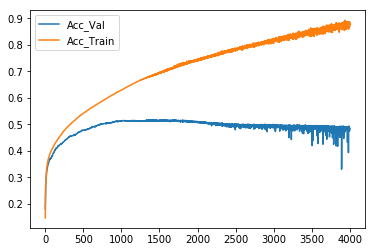

In [15]:
plt.plot(accuracies["accuracies_val"])
plt.plot(accuracies["accuracies_train"])
plt.legend(["Acc_Val", "Acc_Train"])
plt.show()

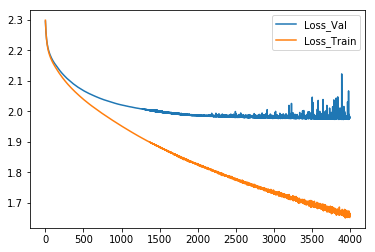

In [16]:
plt.plot(losses["losses_val"])
plt.plot(losses["losses_train"])
plt.legend(["Loss_Val", "Loss_Train"])
plt.show()